In [1]:
import feather
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

In [2]:
class HaDiVe():    
    def __init__(self, data_path, cams_path, prcp_path):
        self.data = self._read_hadive_data(data_path)
        self.cams = self._read_camera_data(cams_path)
        self.prcp = self._read_prcp_data(prcp_path)
        self.selection = None
        self.subselection = None
        self.formatted_df = None
        self.formatted_dur = None
        self.ts_matrix = None
    
    
    def select_boro(self, boro):
        """Assigns boro selection to self.selection.
        
        Args:
            boro (str): "Manhattan", "Brooklyn", "Queens", "Bronx", "Staten Island"
        """
        
        self.subselection = self.formatted_df = self.ts_matrix = None
        
        print "Making boro selection."
        clear_output(wait=True)
        
        cam_list = self.cams[(self.cams.boro == boro) & 
                             (self.cams.people == 1.)].cam_id.unique()
        self.selection = self.data[self.data.cam_id.isin(cam_list)]
        
        return self
    
    
    def select_cam(self, cam_id):
        """Assigns camera selection to self.selection.
        
        Args:
            cam_id (int): camera id
        """
        
        self.subselection = self.formatted_df = self.ts_matrix = None
        
        print "Making camera selection."
        clear_output(wait=True)
        
        self.selection = self.data[self.data.cam_id == cam_id]
        
        return self


    def ss_weekday(self, weekend=False):
        # -- Think of a good way to pull holidays.
        """Reassigns .selection to weekday/weekend subselection.
        
        Args:
            weekend (bool): if True will return weekend
        """
        
        self.formatted_df = self.ts_matrix = None
        
        print "Making weekday selection."
        clear_output(wait=True)
        
        if weekend:
            self.subselection = self.selection[self.selection.index.weekday >= 5]
        else:
            self.subselection = self.selection[self.selection.index.weekday < 5]
            
        return self

    
    def format_subselection(self, dur):
        """Add 'd' and 't' columns to subselection, assign to formatted_df
        Args:
            dur (str): duration to group observations (e.g., 15Min)
        """
        
        if self.formatted_df is None or dur != self.formatted_dur:
            self.formatted_df = self.subselection.copy()
            dt_values = [(t[:10], t[11:16]) for t in (self.subselection.index.round(dur).values).astype(str)]
            self.formatted_df["d"] = [x[0] for x in dt_values]
            self.formatted_df["t"] = [x[1] for x in dt_values]
    
    
    def average_camera_ts(self, dur="15Min", standardize=True):
        """Calculate average time series matrix for each camera 
        based on curren subselection. 
        
        Args:
            dur (str): duration to group observations (e.g., 15Min).
            standardize (bool): standardize resulting matrix.
        """
        
        print "Creating camera time series matrix."
        clear_output(wait=True)
        
        self.format_subselection(dur)
        self.ts_matrix = self.formatted_df.groupby(["cam_id", "t"]).mean().unstack(level=1)
        # -- Convert column names (e.g., HH:MM) to datetime for plotting.
        self.ts_matrix.columns = [pd.to_datetime("9-9-99 " + t) for t in self.ts_matrix.columns.droplevel()]
        # -- Sort by mean pedestrian count in each camera.
        self.ts_matrix["mean"] = self.ts_matrix.mean(axis=1)
        self.ts_matrix = self.ts_matrix.sort_values("mean", ascending=False).drop("mean", axis=1).T
        
        if standardize:
            self.ts_matrix = (self.ts_matrix - self.ts_matrix.mean()) / self.ts_matrix.std()
        
        return self
    
    
    def plot_camera_ts_im(self, title, figsize=(14, 6), cmap="viridis", clim=[-2, 2]):
        """Plot time series image.
        
        Args:
            title (str): Plot title.
            figsize (tup): matplotlib figure size.
            cmap (str): matplotlib color map.
            clim (list): list of color limits (e.g., [min, max]).
        Returns:
            fig: matplotlib figure object.
        """
        
        # -- Create figure, plot matrix, and create color bar.
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
        fig.tight_layout()
        
        im = ax.imshow(self.ts_matrix.T, cmap=cmap, aspect="auto")
        im.set_clim(clim[0], clim[1])
        
        cbar = fig.colorbar(im, ax=ax, pad=0.01)
        cbar.set_label("Pedestrian Count", fontsize=13)
        
        # -- Figure attributes.
        ax.set_xticks(np.arange(0, self.ts_matrix.shape[0], self.ts_matrix.shape[0] / 24))
        ax.set_xticklabels(range(24))
        ax.set_xlabel("Hour", fontsize=13)
        ax.set_yticks([])
        ax.tick_params(axis="both", which="both", labelsize=12)
        ax.set_title(title, fontsize=16)
        ax.grid(alpha=0.4, c="w")
        
        return fig
    
    def average_daily_ts(self, dur="15Min", standardize=True):
        """Calculate average time series matrix for each camera 
        based on curren subselection. 
        
        Args:
            dur (str): duration to group observations (e.g., 15Min).
            standardize (bool): standardize resulting matrix.
        """
        
        print "Creating camera time series matrix."
        clear_output(wait=True)
        
        self.format_subselection(dur)
        self.ts_matrix = self.formatted_df.groupby(["d", "t"])["count"].mean().unstack(level=1).dropna()
        self.ts_matrix.columns = [pd.to_datetime("9-9-99 " + t) for t in self.ts_matrix.columns]
        self.ts_matrix.index = pd.to_datetime(self.ts_matrix.index)
        self.ts_matrix = self.ts_matrix[self.ts_matrix.index.isin(self.prcp[self.prcp.PRCP < 0.05].DATE.values)].T
        
        if standardize:
            self.ts_matrix = (self.ts_matrix - self.ts_matrix.mean()) / self.ts_matrix.std()
        
        self.ts_matrix = self.ts_matrix.T
        
        return self
        
    def plot_daily_ts_diff(self, title, figsize=(14, 6), cmap="viridis"):
        """Plot time series image.
        
        Args:
            title (str): Plot title.
            figsize (tup): matplotlib figure size.
            cmap (str): matplotlib color map.
        Returns:
            fig: matplotlib figure object.
        """
        
        # -- Create figure, plot matrix, and create color bar.
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
        fig.tight_layout()
        
        im = ax.imshow(self.ts_matrix - self.ts_matrix.mean(), cmap="viridis", aspect="auto")
        
        cbar = fig.colorbar(im, ax=ax, pad=0.01)
        cbar.set_label("Pedestrian Count", fontsize=13)
        
        # -- Figure attributes.
        ax.set_xticks(np.arange(0, self.ts_matrix.shape[1], self.ts_matrix.shape[1] / 24))
        ax.set_xticklabels(range(24))
        ax.set_xlabel("Hour", fontsize=13)
        ax.set_yticks(range(len(self.ts_matrix)))
        ax.set_yticklabels(map(lambda x: x.strftime("%b %d"), self.ts_matrix.index))
        ax.tick_params(axis="both", which="both", labelsize=12)
        ax.set_title(title, fontsize=16)
        ax.grid(alpha=0.4, c="w")  
        
        return fig
        
    def _read_hadive_data(self, data_path):
        """Read HaDiVe data file (.csv or .feather) to pandas dataframe. 
        For faster performance, .feather is recommended.
        
        Args:
            data_path (str): path to HaDiVe data file.
        Returns:
            pandas dataframe
        Raises:
            IOError: if data file is not .csv or .feather
        """
        
        if data_path.endswith(".csv"):
            print "Parsing HaDiVe .csv"
            clear_output(wait=True)
            return pd.read_csv(data_path, usecols=["cam_id", "date", "count"], 
                               dtype={"cam_id": int, "date": str, "count": int},
                               infer_datetime_format=True, parse_dates=["date"], 
                               index_col="date")
        
        elif data_path.endswith(".feather"):
            print "Parsing HaDiVe .feather"
            clear_output(wait=True)
            return pd.read_feather(data_path).set_index("date")
        
        else:
            raise IOError("Unaccepted data format (.csv or .feather)")
    
    
    def _read_camera_data(self, cams_path):
        """Read camera data file (.csv) to pandas dataframe.
        
        Args:
            cams_path (str): path to camera data file.
        Returns:
            pandas dataframe
        """
        
        print "Parsing cameras .csv"
        clear_output(wait=True)
        return pd.read_csv(cams_path, usecols=["cam_id", "people", "boro"])
    
    
    def _read_prcp_data(self, prcp_path):
        """Read precipitation data file (.csv) to pandas dataframe.
        
        Args:
            prcp_path (str): path to NOAA precipitation data file.
        Returns:
            pandas dataframe
        """
        
        print "Parsing NOAA precipitation .csv"
        clear_output(wait=True)
        return pd.read_csv(prcp_path, usecols=["DATE", "PRCP"], parse_dates=["DATE"])

In [3]:
hdv = HaDiVe("../data/external/hadive-data.feather", 
             "../data/external/cameras.csv",
             "../data/external/nyc_centralpark_2017precip.csv")

Parsing NOAA precipitation .csv


In [4]:
hdv.select_boro("Manhattan").ss_weekday()

<__main__.HaDiVe instance at 0x10c95f098>

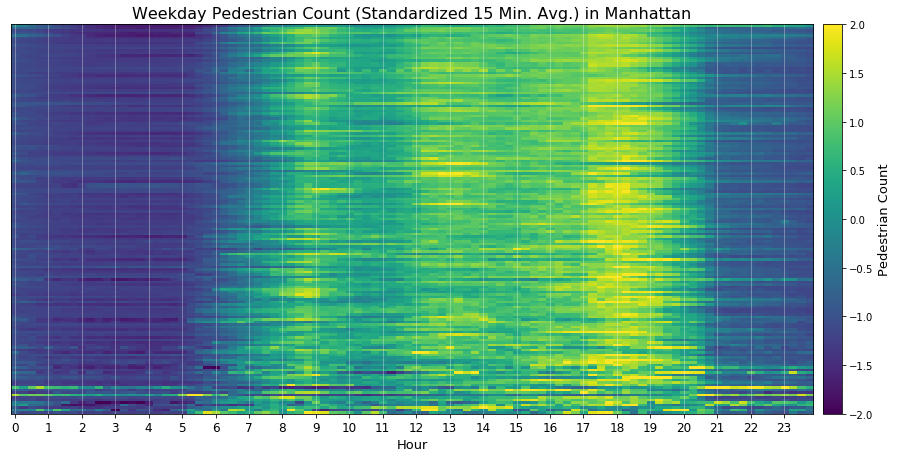

In [5]:
mn_wd_cam_im = hdv.average_camera_ts(standardize=True) \
              .plot_camera_ts_im("Weekday Pedestrian Count (Standardized 15 Min. Avg.) in Manhattan")

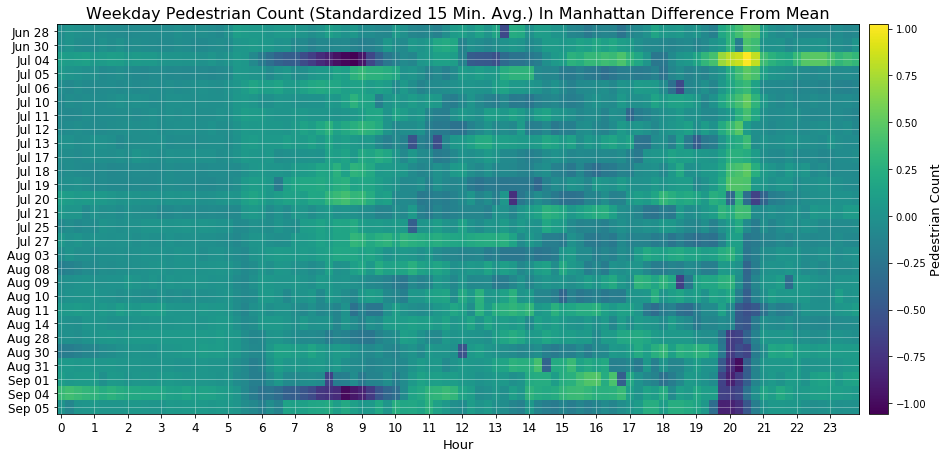

In [7]:
mn_wd_day_im = hdv.average_daily_ts().plot_daily_ts_diff("Weekday Pedestrian Count (Standardized 15 Min. Avg.) In Manhattan Difference From Mean")